In [1]:
import numpy as np
from scipy.spatial import Voronoi, KDTree
from numba import njit
from numba import prange
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [13]:
dt = 1e-5
mobility_r = 10.0
area_kappa = 5.0
a0 = 1.0
gamma_b = 0.1
total_steps = 50000
steps_voronoi = 10
k = 12
np.random.seed(42)
N = 512
R0 = 50
k_wall = 10.0
r_wall = R0*1.1
u0, v0 = np.random.rand(N), np.random.rand(N)
r = np.zeros((N, 2))
r[:,0] = R0*np.sqrt(u0)*np.cos(2*np.pi*v0)
r[:,1] = R0*np.sqrt(u0)*np.sin(2*np.pi*v0)
sigma = np.repeat(np.eye(2)[np.newaxis, :, :], N, axis=0)

In [14]:
for step in range(total_steps):
    if(step % steps_voronoi == 0):
        neighbors = KDTree(r).query(r, k=k+1)[1][:,1:]
    r_ij = r[:, np.newaxis, :] - r[neighbors, :]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    sigma_ij_sum = sigma[:, np.newaxis, :, :] + sigma[neighbors, :, :]
    sigma_ij_sum_inv = np.linalg.inv(sigma_ij_sum)
    sigma_ij_sum_det = np.linalg.det(sigma_ij_sum)
    sigma_inv_on_r_ij =  np.einsum('...ij,...j->...i', sigma_ij_sum_inv, r_ij)
    quad_form_ij = 0.5*np.einsum('...i,...i->...', r_ij, sigma_inv_on_r_ij)
    shape_form_ij = 0.5*np.log((sigma_det[:,np.newaxis]*sigma_det[neighbors]/sigma_ij_sum_det))
    distances_ij = np.exp(-quad_form_ij + shape_form_ij)
    strengths_ij = dt*gamma_b*np.exp(-distances_ij)
    distance_sigma_forces_ij = -0.5 * sigma_inv_on_r_ij[:,:,:,None] * sigma_inv_on_r_ij[:,:,None,:] + 0.5 * sigma_inv[:,None,:,:] - 0.5 * sigma_ij_sum_inv
    #sigma += np.sum(strengths_ij[:,:,None,None]*distance_sigma_forces_ij, axis=1)
    #sigma += (area_kappa*dt) * (a0 - np.sqrt(sigma_det))[:,None,None] * sigma_inv
    r += mobility_r*np.sum(strengths_ij[:,:,None]*sigma_inv_on_r_ij, axis=1)
    r_mod = np.linalg.norm(r, axis=1)
    wall_strength = (dt*k_wall) * (r_wall - r_mod)[:, np.newaxis] * (r / r_mod[:, np.newaxis])
    wall_strength[r_mod < r_wall] = 0.0
    r +=  wall_strength

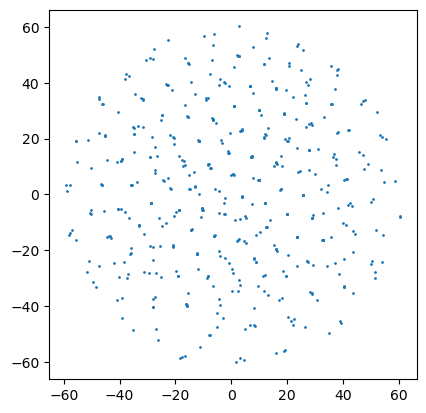

In [15]:
plt.scatter(r[:,0], r[:,1],s=1)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
dt = 1e-5
total_steps = 10000

In [ ]:
r0 = 1.0
gamma_b = 5.0
kappa = 2.0
a0 = 1.0
for angle in np.linspace(0, 2*np.pi, 20):
    sigma_i = np.eye(2)
    sigma_j = np.eye(2)
    r = np.zeros(2)
    r[0] = r0 * np.cos(angle)
    r[1] = r0 * np.sin(angle)
    for step in range(total_steps):
        sigma_i_det = np.linalg.det(sigma_i)
        sigma_j_det = np.linalg.det(sigma_j)
        sigma_i_inv = np.linalg.inv(sigma_i)
        sigma_j_inv = np.linalg.inv(sigma_j)
        sigma_ij = sigma_i + sigma_j
        sigma_ij_inv = np.linalg.inv(sigma_ij)
        distance = 0.5*(r).T @ sigma_ij_inv @ (r) + np.log(sigma_i_det)*0.5 + np.log(sigma_j_det)*0.5  - np.log(np.linalg.det(sigma_ij))*0.5
        sigma_ij_inv_r = sigma_ij_inv @ (r)
        distance_grad_common = -0.5 * sigma_ij_inv_r @ sigma_ij_inv
        distance_grad_i = distance_grad_common + 0.5 * sigma_i_inv - 0.5 * sigma_ij_inv
        distance_grad_j = distance_grad_common + 0.5 * sigma_j_inv - 0.5 * sigma_ij_inv
        strength = np.exp(-distance)*(dt)

        sigma_i += strength * distance_grad_i + (kappa*0.5)*dt*(a0-np.sqrt(sigma_i_det))*sigma_i_inv
        sigma_j += strength * distance_grad_j + (kappa*0.5)*dt*(a0-np.sqrt(sigma_j_det))*sigma_j_inv
    vals, vecs = np.linalg.eig(sigma_i)
    
    plt.quiver(0,0,r[0], r[1], color='r', angles='xy', scale_units='xy', scale=1)
    ell = Ellipse(
            xy=(r[0], r[1]),
            width=2*np.sqrt(vals[0])/np.sqrt(np.pi), height=2*np.sqrt(vals[1])/np.sqrt(np.pi),
            angle=np.degrees(np.arctan2(vecs[1,0], vecs[0,0])), fill=False,)
    plt.gca().add_patch(ell)
    #plt.quiver(r[0], r[1], vecs[0,0]*np.sqrt(vals[0]), vecs[1,0]*np.sqrt(vals[0]), color='b', angles='xy', scale_units='xy', scale=1)
    #plt.quiver(r[0], r[1], vecs[0,1]*np.sqrt(vals[1]), vecs[1,1]*np.sqrt(vals[1]), color='b', angles='xy', scale_units='xy', scale=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()